# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/Fine_Food_Review/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:53<00:00, 2104.52it/s]


In [0]:
#Taking out only Text, Time and Score columns in another dataframe
df = final[['Text','Time','Score']]
print("Shape of final data:- ",df.shape)
counts = df['Score'].value_counts()
print(counts)
print("Ratio of positive reviews:- ",counts[1]/(counts[0]+counts[1]))
print("Ratio of negative points:- ",counts[0]/(counts[0]+counts[1]))

#Sorting the values according to time for time based splitting
df['Text'] = preprocessed_reviews
df = df.sort_values('Time',axis=0,ascending=True)
df = df.reset_index(drop=True)
#print(df[df.isnull().any(axis=1)])
df.to_csv("/content/drive/My Drive/Colab Notebooks/Fine_Food_Review/corpus_assign.csv", index = False)
df.head(5)

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

### Loading the already prepared corpus from drive


In [0]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fine_Food_Review/corpus1.csv")

#Taking out 100K datapoints to work on
df1k = df.loc[0:99999,:]
print("Shape of the dataframe to be worked on:- ",df1k.shape)
print(df1k['Score'].value_counts())
df1k.head(5)

Shape of the dataframe to be worked on:-  (100000, 3)
1    87729
0    12271
Name: Score, dtype: int64


,Text,Time,Score
0,witti littl book make son laugh loud recit car...,939340800,1
1,rememb see show air televis year ago child sis...,940809600,1
2,beetlejuic well written movi everyth excel act...,944092800,1
3,twist rumplestiskin captur film star michael k...,944438400,1
4,beetlejuic excel funni movi keaton hilari wack...,946857600,1


### Time based splitting into train and test data

In [0]:
#Time based splitting into train and test data
from sklearn.model_selection import TimeSeriesSplit
def timesplit(x,y):
    ts = TimeSeriesSplit(n_splits = 4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = timesplit(df1k["Text"].values,df1k["Score"].values)

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
cv = CountVectorizer(ngram_range=(1,2),max_features=10000) #in scikit-learn
bow_train = cv.fit_transform(x_train)
print("some feature names ", cv.get_feature_names()[:10])
print('='*50)

bow_test = cv.transform(x_test)
print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])
print("Train data shape:- ",bow_train.shape)
print("Test data shape:- ",bow_test.shape)

some feature names  ['abil', 'abl', 'abl buy', 'abl eat', 'abl enjoy', 'abl find', 'abl get', 'abl make', 'abl order', 'abl purchas']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (80000, 10000)
the number of unique words  10000
Train data shape:-  (80000, 10000)
Test data shape:-  (20000, 10000)


In [0]:
%%time
#Feature Engineering -> Adding the column of word count
from scipy.sparse import hstack,csr_matrix
from imblearn.over_sampling import SMOTE
def wordCount(x):
  word_count = []
  for sent in x:
    word_count.append(len(sent.split()))
  return word_count
bow_train_fe = csr_matrix(hstack((bow_train,np.array(wordCount(x_train)).astype(int)[:,None])))
bow_test_fe = csr_matrix(hstack((bow_test,np.array(wordCount(x_test)).astype(int)[:,None])))
print("Train data shape:- ",bow_train_fe.shape)
print("Test data shape:- ",bow_test_fe.shape)
print("First five word counts of bow_train:-\n",bow_train_fe[:5,-1])
print("First five word counts of bow_test:-\n",bow_test_fe[:5,-1])

#Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean = False)
bow_train = sc.fit_transform(bow_train_fe)
bow_test = sc.transform(bow_test_fe)

Train data shape:-  (80000, 10001)
Test data shape:-  (20000, 10001)
First five word counts of bow_train:-
   (0, 0)	35
  (1, 0)	35
  (2, 0)	13
  (3, 0)	21
  (4, 0)	25
First five word counts of bow_test:-
   (0, 0)	11
  (1, 0)	20
  (2, 0)	16
  (3, 0)	36
  (4, 0)	13
CPU times: user 795 ms, sys: 22.1 ms, total: 817 ms
Wall time: 840 ms


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=10000)
tf_idf_vect.fit(x_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

tfidf_train = tf_idf_vect.transform(x_train)
tfidf_test = tf_idf_vect.transform(x_test)
print("the type of count vectorizer ",type(tfidf_train))
print("the shape of out text TFIDF vectorizer ",tfidf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_train.get_shape()[1])
print("Train data shape:- ",tfidf_train.shape)
print("Test data shape:- ",tfidf_test.shape)

some sample features(unique words in the corpus) ['abil', 'abl', 'abl buy', 'abl eat', 'abl enjoy', 'abl find', 'abl get', 'abl make', 'abl order', 'abl purchas']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (80000, 10000)
the number of unique words including both unigrams and bigrams  10000
Train data shape:-  (80000, 10000)
Test data shape:-  (20000, 10000)


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
def sent_list(x):
  i=0
  list_of_sentance=[]
  for sentance in x:
      list_of_sentance.append(sentance.split())
  return list_of_sentance

sent_train = sent_list(x_train)
sent_test = sent_list(x_test)

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(sent_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excel', 0.8314294219017029), ('good', 0.8258781433105469), ('fantast', 0.8220158219337463), ('terrif', 0.8206127882003784), ('wonder', 0.772398054599762), ('nice', 0.741980791091919), ('awesom', 0.73618483543396), ('perfect', 0.7343125343322754), ('fabul', 0.6513631343841553), ('decent', 0.612832248210907)]
[('greatest', 0.7563369870185852), ('best', 0.7235152721405029), ('aw', 0.6189620494842529), ('nicest', 0.6129353642463684), ('tastiest', 0.6034427881240845), ('horribl', 0.5926377773284912), ('terribl', 0.587786853313446), ('ined', 0.579389214515686), ('weakest', 0.5608049035072327), ('smoothest', 0.5556745529174805)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  11801
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'amp', 'song', 'student', 'teach']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
def avgw2v(x):
  avgw2v_vec = [] # the avg-w2v for each sentence/review is stored in this list
  for sent in tqdm(x): # for each review/sentence
      sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words:
              vec = w2v_model.wv[word]
              sent_vec += vec
              cnt_words += 1
      if cnt_words != 0:
          sent_vec /= cnt_words
      avgw2v_vec.append(sent_vec)
  #print(len(sent_vectors))
  #print(len(sent_vectors[0]))
  return avgw2v_vec

avgw2v_train = np.array(avgw2v(sent_train))
print("Shape of avg word2vec train data:- ",avgw2v_train.shape)
avgw2v_test = np.array(avgw2v(sent_test))
print("Shape of avg word2vec test data:- ",avgw2v_test.shape)

  0%|          | 65/20000 [00:00<00:30, 645.02it/s]

Shape of avg word2vec train data:-  (80000, 50)


100%|██████████| 20000/20000 [00:28<00:00, 709.54it/s]

Shape of avg word2vec test data:-  (20000, 50)


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidfw2v(x):
  tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
  row=0;
  for sent in tqdm(x): # for each review/sentence 
      sent_vec = np.zeros(50) # as word vectors are of zero length
      weight_sum =0; # num of words with a valid vector in the sentence/review
      for word in sent: # for each word in a review/sentence
          if word in w2v_words and word in tfidf_feat:
              vec = w2v_model.wv[word]
  #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
              # to reduce the computation we are 
              # dictionary[word] = idf value of word in whole courpus
              # sent.count(word) = tf valeus of word in this review
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_sent_vectors.append(sent_vec)
      row += 1
  return tfidf_sent_vectors     

tfidfw2v_train = np.array(tfidfw2v(sent_train))
tfidfw2v_test = np.array(tfidfw2v(sent_test))
print("\nShape of tfidf avgw2v train vector:- ",tfidfw2v_train.shape)
print("\nShape of tfidf avgw2v test vector:- ",tfidfw2v_test.shape)

100%|██████████| 20000/20000 [06:07<00:00, 54.44it/s]


Shape of tfidf avgw2v train vector:-  (80000, 50)

Shape of tfidf avgw2v test vector:-  (20000, 50)


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [0]:
%%time
# Parameter tuning using GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(class_weight = 'balanced')
param_grid = {"n_estimators":[50,150,300,400],"max_depth":[10,50,100,200]}
gs = GridSearchCV(classifier,param_grid,cv=5,scoring="roc_auc",n_jobs = -1)
gs.fit(bow_train_fe,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 200, 'n_estimators': 400}
Best Score:-  0.934736283335762
CPU times: user 14min 7s, sys: 1.17 s, total: 14min 8s
Wall time: 3h 12min 42s


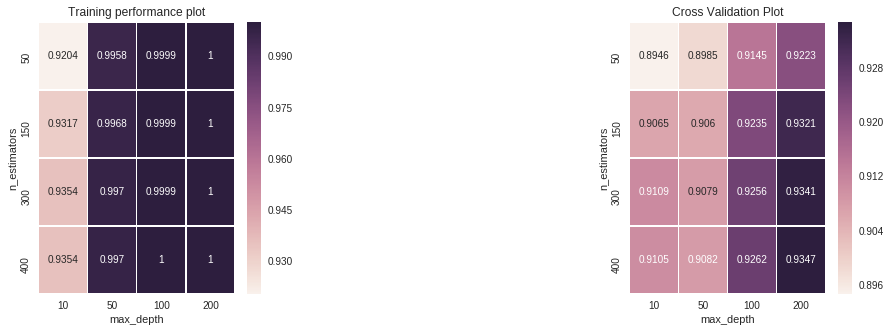

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
n_estimators = [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = RandomForestClassifier(n_estimators = 400, max_depth = 200,n_jobs=-1,class_weight='balanced')
classifier.fit(bow_train_fe,y_train)
y_pred = classifier.predict_proba(bow_test_fe)[:,1]
fpr, tpr, treshold = roc_curve(y_test, y_pred)
#print("Test accuracy score:- ",accuracy_score(y_test,y_pred))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(bow_train_fe)[:,1]))

Test AUC score:-  0.9390145246919503
Training AUC score:-  0.9999999844539875
CPU times: user 20min 16s, sys: 1.48 s, total: 20min 18s
Wall time: 10min 12s


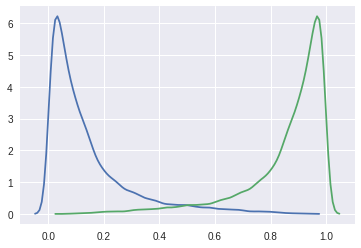

In [0]:
sns.kdeplot(classifier.predict_proba(bow_test_fe)[:,0])
sns.kdeplot(classifier.predict_proba(bow_test_fe)[:,1])


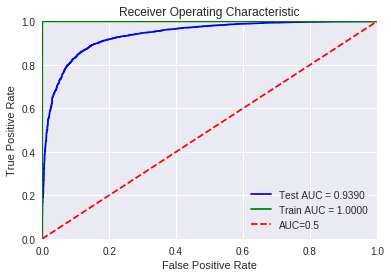

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(bow_train_fe)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(bow_train_fe)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[  846  1832]
 [  108 17214]]


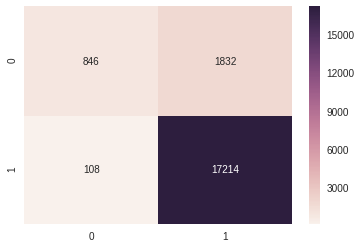

In [0]:
cm = confusion_matrix(y_test,classifier.predict(bow_test_fe))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

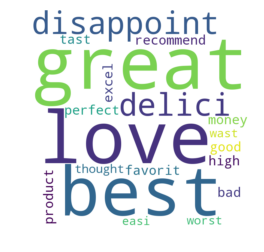

In [0]:
from wordcloud import WordCloud
ft = classifier.feature_importances_.argsort()
ft = np.delete(ft,list(ft).index(len(ft)-1))        #Removing last feature(length of review)
words = np.take(np.array(cv.get_feature_names()),ft)[::-1]
feat_imp = np.take(classifier.feature_importances_,ft)[::-1]
text=''
for word in words[:20]:
  text = text + " " + word
wc = WordCloud(width = 800, height = 800,background_color ='white').generate(text)
#plt.figure() 
plt.imshow(wc, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0)
plt.show() 

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [0]:
%%time
# Parameter tuning using GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(class_weight = 'balanced')
param_grid = {"n_estimators":[50,150,300,400],"max_depth":[50,100,200,300]}
gs = GridSearchCV(classifier,param_grid,cv=5,scoring="roc_auc",n_jobs = -1)
gs.fit(tfidf_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 300, 'n_estimators': 400}
Best Score:-  0.9360526303336508
CPU times: user 13min 37s, sys: 2.04 s, total: 13min 39s
Wall time: 4h 14min 5s


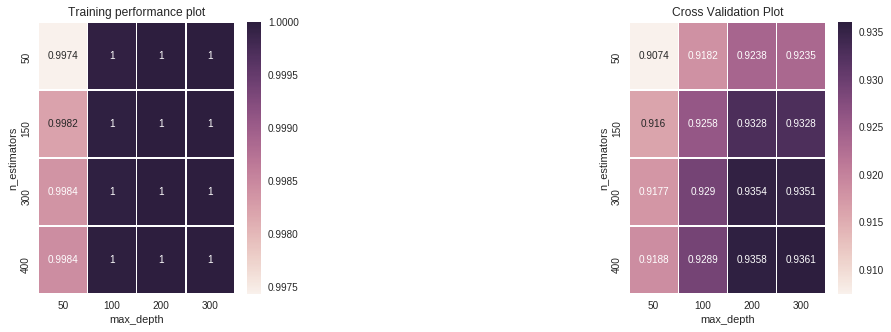

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
n_estimators = [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = RandomForestClassifier(n_estimators = 400, max_depth = 300,n_jobs=-1,class_weight='balanced')
classifier.fit(tfidf_train,y_train)
y_pred = classifier.predict_proba(tfidf_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(tfidf_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(tfidf_train)[:,1]))

Test accuracy score:-  0.90115
Test AUC score:-  0.9410557175647419
Training AUC score:-  0.9999999948179958
CPU times: user 16min 16s, sys: 1.24 s, total: 16min 17s
Wall time: 8min 10s


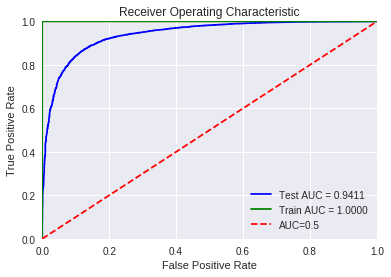

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict(tfidf_train))
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict(tfidf_train)))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[  765  1913]
 [   64 17258]]


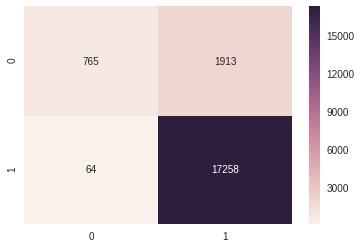

In [0]:
#Confusion Matrix
cm = confusion_matrix(y_test,classifier.predict(tfidf_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

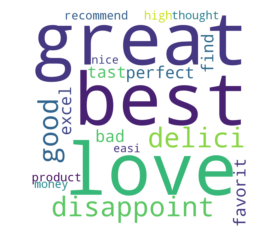

In [0]:
from wordcloud import WordCloud
ft = classifier.feature_importances_.argsort()
#ft = np.delete(ft,list(ft).index(len(ft)-1))
words = np.take(np.array(tf_idf_vect.get_feature_names()),ft)[::-1]
feat_imp = np.take(classifier.feature_importances_,ft)[::-1]
text=''
for word in words[:20]:
  text = text + " " + word
wc = WordCloud(width = 800, height = 800,background_color ='white').generate(text)
#plt.figure() 
plt.imshow(wc, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0)
plt.show() 

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [0]:
%%time
# Parameter tuning using GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(class_weight = 'balanced')
param_grid = {"n_estimators":[50,150,300,400],"max_depth":[50,100,200,300]}
gs = GridSearchCV(classifier,param_grid,cv=5,scoring="roc_auc",n_jobs = -1)
gs.fit(avgw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 300, 'n_estimators': 400}
Best Score:-  0.8917333498911728
CPU times: user 4min 10s, sys: 541 ms, total: 4min 10s
Wall time: 1h 46min 19s


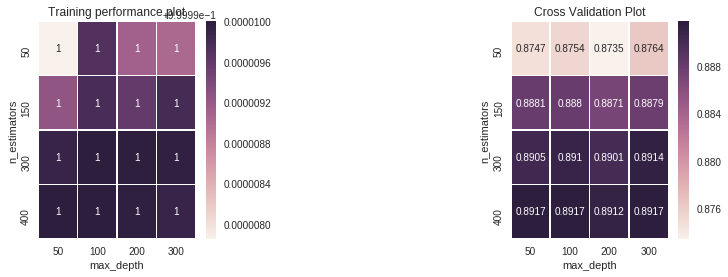

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
n_estimators = [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (12,4))
plt.subplot(131)
train_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = RandomForestClassifier(n_estimators = 400, max_depth = 300,n_jobs=-1,class_weight='balanced')
classifier.fit(avgw2v_train,y_train)
y_pred = classifier.predict_proba(avgw2v_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(avgw2v_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(avgw2v_train)[:,1]))

Test accuracy score:-  0.8856
Test AUC score:-  0.8969726234511294
Training AUC score:-  0.9999999992597136
CPU times: user 5min 40s, sys: 515 ms, total: 5min 41s
Wall time: 4min 24s


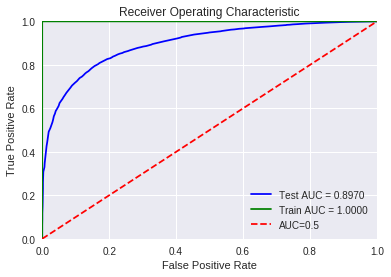

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict(avgw2v_train))
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict(avgw2v_train)))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[  557  2121]
 [  167 17155]]


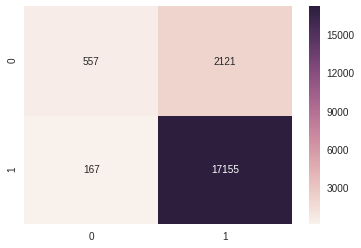

In [0]:
#Confusion Matrix
cm = confusion_matrix(y_test,classifier.predict(avgw2v_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
%%time
# Parameter tuning using GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(class_weight = 'balanced')
param_grid = {"n_estimators":[50,150,300,400],"max_depth":[50,100,200,300]}
gs = GridSearchCV(classifier,param_grid,cv=5,scoring="roc_auc",n_jobs = -1)
gs.fit(tfidfw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 100, 'n_estimators': 400}
Best Score:-  0.8661338427712896
CPU times: user 5min 54s, sys: 588 ms, total: 5min 55s
Wall time: 2h 40min 57s


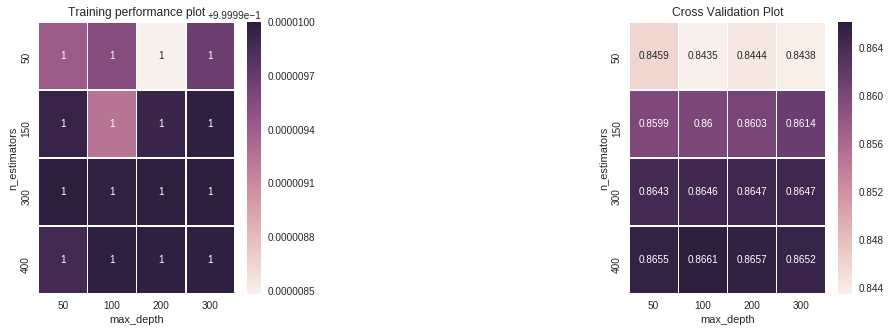

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
n_estimators = [gs.cv_results_['params'][i]['n_estimators'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'n_estimators':n_estimators,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("n_estimators","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = RandomForestClassifier(n_estimators = 400, max_depth = 100,n_jobs=-1,class_weight='balanced')
classifier.fit(tfidfw2v_train,y_train)
y_pred = classifier.predict_proba(tfidfw2v_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(tfidfw2v_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(tfidfw2v_train)[:,1]))

Test accuracy score:-  0.8791
Test AUC score:-  0.8696471326960866
Training AUC score:-  0.999999997779141
CPU times: user 6min 24s, sys: 783 ms, total: 6min 25s
Wall time: 3min 39s


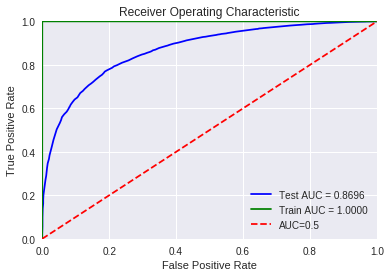

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(tfidfw2v_train)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(tfidfw2v_train)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[  387  2291]
 [  127 17195]]


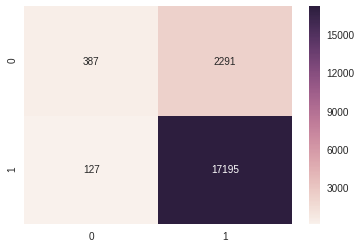

In [0]:
#Confusion Matrix
cm = confusion_matrix(y_test,classifier.predict(tfidfw2v_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [0]:
#To get optimum number of tress using cv function of xgboost
# Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from xgboost import DMatrix
from xgboost import cv as cv_xg
from xgboost import XGBClassifier
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, max_depth = 5,scale_pos_weight=weight,n_jobs=-1)
xgb_train = DMatrix(bow_train,y_train)
xgb_param = classifier.get_xgb_params()
cv_res = cv_xg(xgb_param,xgb_train,num_boost_round=xgb_param['n_estimators'],early_stopping_rounds=50,metrics='auc')
print("Optimal number of trees:- ",cv_res.shape[0])

Optimal number of trees:-  1000


In [0]:
%%time
# Parameter tuning using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, scale_pos_weight=weight)
param_grid = {"max_depth":range(3,13,3),"min_child_weight":range(1,8,2)}
gs = GridSearchCV(classifier,param_grid,cv=3,scoring="roc_auc",n_jobs = -1)
gs.fit(bow_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 9, 'min_child_weight': 3}
Best Score:-  0.9416518642675552
CPU times: user 7min 47s, sys: 354 ms, total: 7min 47s
Wall time: 3h 16min 44s


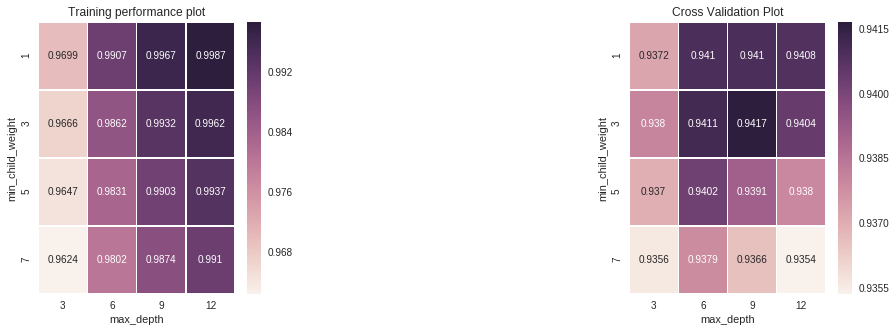

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
min_child_weight = [gs.cv_results_['params'][i]['min_child_weight'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, max_depth = 9, min_child_weight=3,n_jobs=-1,scale_pos_weight=weight)
classifier.fit(bow_train,y_train)
y_pred = classifier.predict_proba(bow_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(bow_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(bow_train)[:,1]))

Test accuracy score:-  0.90375
Test AUC score:-  0.9487069545701983
Training AUC score:-  0.989900903068019
CPU times: user 12min 18s, sys: 448 ms, total: 12min 19s
Wall time: 9min 27s


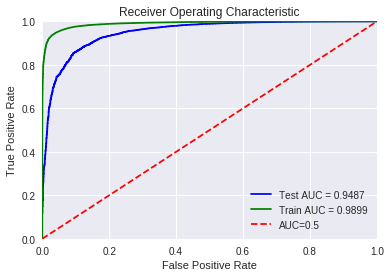

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(bow_train)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(bow_train)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[ 2239   439]
 [ 1486 15836]]


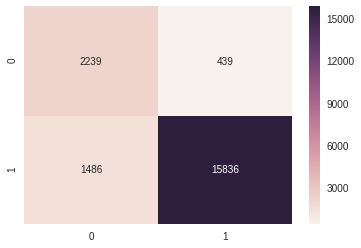

In [0]:
cm = confusion_matrix(y_test,classifier.predict(bow_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [0]:
#To get optimum number of tress using cv function of xgboost
# Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from xgboost import DMatrix
from xgboost import cv as cv_xg
from xgboost import XGBClassifier
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, max_depth = 7,scale_pos_weight=weight,n_jobs=-1)
xgb_train = DMatrix(tfidf_train,y_train)
xgb_param = classifier.get_xgb_params()
cv_res = cv_xg(xgb_param,xgb_train,num_boost_round=xgb_param['n_estimators'],early_stopping_rounds=50,metrics='auc')
print("Optimal number of trees:- ",cv_res.shape[0])

Optimal number of trees:-  1000


In [0]:
cv_res.loc[cv_res.shape[0]-10:,:]

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
990,0.942767,0.001894,0.995920,0.000125
991,0.942772,0.001878,0.995929,0.000121
992,0.942782,0.001874,0.995937,0.000126
993,0.942784,0.001869,0.995945,0.000126
994,0.942784,0.001885,0.995950,0.000126
995,0.942791,0.001886,0.995959,0.000130
996,0.942792,0.001897,0.995967,0.000127
997,0.942785,0.001885,0.995972,0.000125
998,0.942786,0.001887,0.995977,0.000126
999,0.942790,0.001886,0.995981,0.000125


In [0]:
%%time
# Parameter tuning using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = cv_res.shape[0], scale_pos_weight=weight)
param_grid = {"max_depth":range(3,13,3),"min_child_weight":range(1,8,2)}
gs = GridSearchCV(classifier,param_grid,cv=3,scoring="roc_auc",n_jobs = -1)
gs.fit(tfidf_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 9, 'min_child_weight': 1}
Best Score:-  0.9412979647725881
CPU times: user 14min 24s, sys: 428 ms, total: 14min 25s
Wall time: 5h 40min 40s


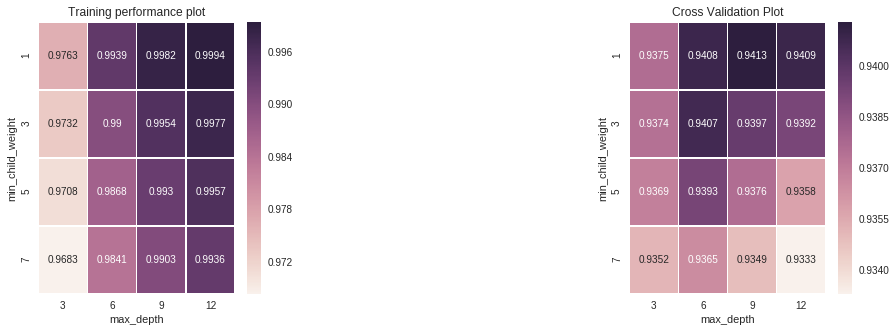

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
min_child_weight = [gs.cv_results_['params'][i]['min_child_weight'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = XGBClassifier(n_estimators = cv_res.shape[0], max_depth=9,booster='gbtree', scale_pos_weight=weight, min_child_weight=1,n_jobs=-1)
classifier.fit(tfidf_train,y_train)
y_pred = classifier.predict_proba(tfidf_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(tfidf_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(tfidf_train)[:,1]))

Test accuracy score:-  0.91295
Test AUC score:-  0.9494990398013156
Training AUC score:-  0.9969070475080859
CPU times: user 14min 43s, sys: 411 ms, total: 14min 43s
Wall time: 14min 43s


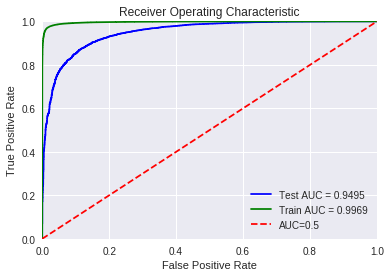

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(tfidf_train)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(tfidf_train)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[ 2142   536]
 [ 1205 16117]]


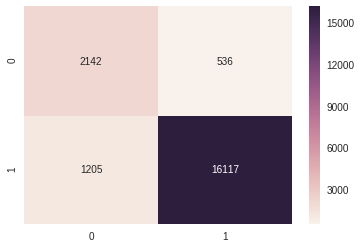

In [0]:
cm = confusion_matrix(y_test,classifier.predict(tfidf_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [0]:
#To get optimum number of tress using cv function of xgboost
# Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from xgboost import DMatrix
from xgboost import cv as cv_xg
from xgboost import XGBClassifier
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, max_depth = 6,scale_pos_weight=weight,n_jobs=-1)
xgb_train = DMatrix(avgw2v_train,y_train)
xgb_param = classifier.get_xgb_params()
cv_res = cv_xg(xgb_param,xgb_train,num_boost_round=xgb_param['n_estimators'],early_stopping_rounds=50,metrics='auc')
print("Optimal number of trees:- ",cv_res.shape[0])

Optimal number of trees:-  519


In [0]:
%%time
# Parameter tuning using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 519, scale_pos_weight=weight)
param_grid = {"max_depth":range(3,13,3),"min_child_weight":range(1,8,2)}
gs = GridSearchCV(classifier,param_grid,cv=3,scoring="roc_auc",n_jobs = -1)
gs.fit(avgw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 12, 'min_child_weight': 5}
Best Score:-  0.9102892056005548
CPU times: user 11min 30s, sys: 395 ms, total: 11min 30s
Wall time: 2h 45min 53s


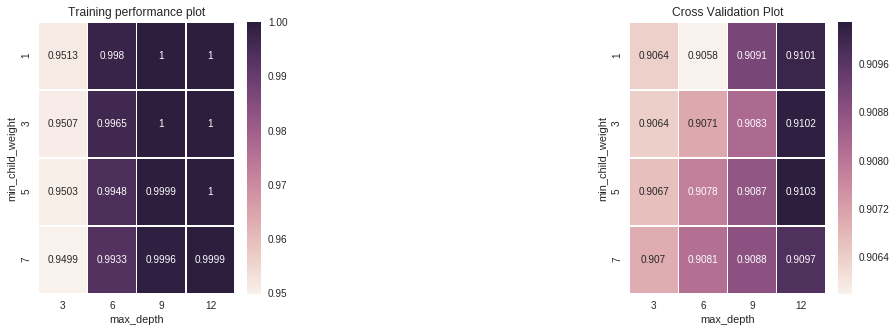

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
min_child_weight = [gs.cv_results_['params'][i]['min_child_weight'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = XGBClassifier(n_estimators = 519, max_depth=12,booster='gbtree', scale_pos_weight=weight, min_child_weight=5,n_jobs=-1)
classifier.fit(avgw2v_train,y_train)
y_pred = classifier.predict_proba(avgw2v_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(avgw2v_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(avgw2v_train)[:,1]))

Test accuracy score:-  0.89905
Test AUC score:-  0.9166315931796274
Training AUC score:-  0.9999733726415889
CPU times: user 7min 54s, sys: 256 ms, total: 7min 54s
Wall time: 7min 55s


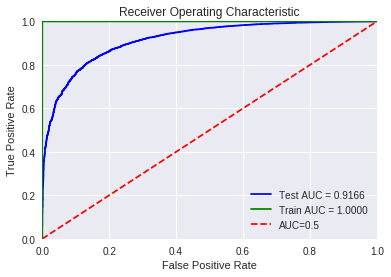

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(avgw2v_train)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(avgw2v_train)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[ 1694   984]
 [ 1035 16287]]


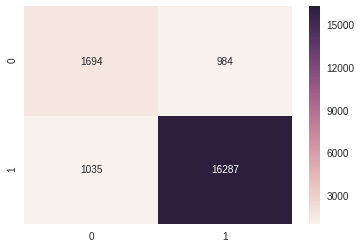

In [0]:
cm = confusion_matrix(y_test,classifier.predict(avgw2v_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
#To get optimum number of tress using cv function of xgboost
# Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
from xgboost import DMatrix
from xgboost import cv as cv_xg
from xgboost import XGBClassifier
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 1000, max_depth = 6,scale_pos_weight=weight,n_jobs=-1)
xgb_train = DMatrix(tfidfw2v_train,y_train)
xgb_param = classifier.get_xgb_params()
cv_res = cv_xg(xgb_param,xgb_train,num_boost_round=xgb_param['n_estimators'],early_stopping_rounds=50,metrics='auc')
print("Optimal number of trees:- ",cv_res.shape[0])

Optimal number of trees:-  236


In [0]:
%%time
# Parameter tuning using GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
weight = float(np.sum(y_train==0)/np.sum(y_train==1))
classifier = XGBClassifier(n_estimators = 236, scale_pos_weight=weight)
param_grid = {"max_depth":range(3,13,3),"min_child_weight":range(1,8,2)}
gs = GridSearchCV(classifier,param_grid,cv=3,scoring="roc_auc",n_jobs = -1)
gs.fit(tfidfw2v_train,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best Score:- ",gs.best_score_)

Best parameter:-  {'max_depth': 12, 'min_child_weight': 5}
Best Score:-  0.884228506214249
CPU times: user 3min 38s, sys: 154 ms, total: 3min 38s
Wall time: 1h 9min 27s


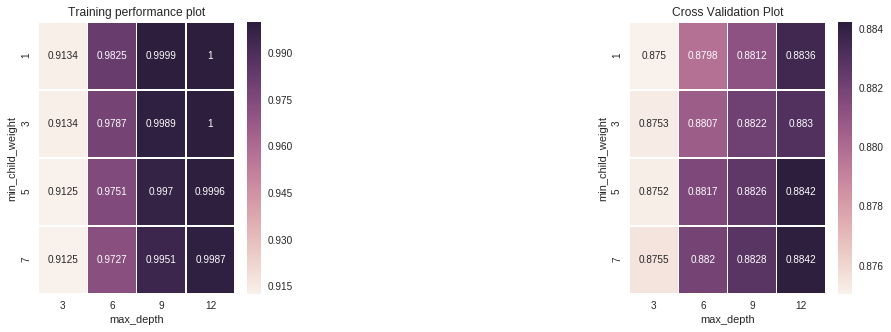

In [0]:
#Performance plots of train and cross validation
max_depth = [gs.cv_results_['params'][i]['max_depth'] for i in range(len(gs.cv_results_['params']))]
min_child_weight = [gs.cv_results_['params'][i]['min_child_weight'] for i in range(len(gs.cv_results_['params']))]
plt.figure(1,figsize = (15,5))
plt.subplot(131)
train_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_train_score']})
train_df = train_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(train_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Training performance plot")
plt.subplot(133)
cv_df = pd.DataFrame({'min_child_weight':min_child_weight,'max_depth':max_depth,'roc_auc':gs.cv_results_['mean_test_score']})
cv_df = cv_df.pivot("min_child_weight","max_depth","roc_auc")
ax = sns.heatmap(cv_df,annot=True,fmt='.4g',linewidths=.5)
plt.title("Cross Validation Plot")
plt.show()

In [0]:
%%time
#Testing the model with tuned parameters
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
classifier = XGBClassifier(n_estimators = 236, max_depth=12,booster='gbtree', scale_pos_weight=weight, min_child_weight=5,n_jobs=-1)
classifier.fit(tfidfw2v_train,y_train)
y_pred = classifier.predict_proba(tfidfw2v_test)[:,1]
print("Test accuracy score:- ",accuracy_score(y_test,classifier.predict(tfidfw2v_test)))
print("Test AUC score:- ",roc_auc_score(y_test, y_pred))
print("Training AUC score:- ",roc_auc_score(y_train,classifier.predict_proba(tfidfw2v_train)[:,1]))

Test accuracy score:-  0.8774
Test AUC score:-  0.8888960530492205
Training AUC score:-  0.9993146806855456
CPU times: user 3min 45s, sys: 74.8 ms, total: 3min 45s
Wall time: 3min 45s


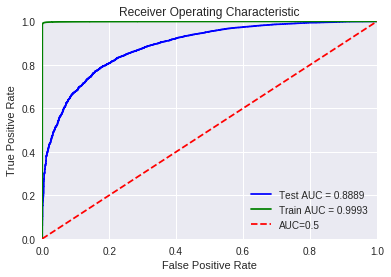

In [0]:
#ROC_AUC curve of test and train
plt.title('Receiver Operating Characteristic')
fpr, tpr, treshold = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.4f' % auc(fpr,tpr))
fpr,tpr,_ = roc_curve(y_train,classifier.predict_proba(tfidfw2v_train)[:,1])
plt.plot(fpr, tpr, 'g', label = 'Train AUC = %0.4f' % roc_auc_score(y_train,classifier.predict_proba(tfidfw2v_train)[:,1]))
plt.plot([0, 1], [0, 1],'r--',label = 'AUC=0.5')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Confusion Matrix
 [[ 1617  1061]
 [ 1391 15931]]


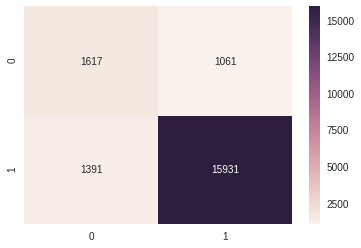

In [0]:
cm = confusion_matrix(y_test,classifier.predict(tfidfw2v_test))
print("Confusion Matrix\n",cm)
sns.heatmap(cm,annot=True,fmt='d')

# [6] Conclusions

## Results of Random Forest:-

| Model | Hyperparameter(n_estimators,max _depth) | Train AUC | Test AUC |
| - | - | - | - |
| Bag of Words | n_estimators=400, max_depth=200 | 0.99 | 0.9396 |
|Tfidf | n_estimators=400, max_depth=300 | 0.99 | 0.9411 |
| Avg Word2Vec | n_estimators=400, max_depth=300 | 0.99 | 0.8969 |
| Tfidf Word2Vec | n_estimators=400, max_depth=100| 0.99 | 0.8696 |

## Results of XGBOOST:-

| Model | Hyperparameter(n_estimators,max _depth,min_child_weight) | Train AUC | Test AUC |
| - | - | - | - |
| Bag of Words | n_estimators=1000, max_depth=9,min_child_weight=3 | 0.99 | 0.9487 |
|Tfidf | n_estimators=1000, max_depth=9, min_child_weight=1 | 0.99 | 0.9494 |
| Avg Word2Vec | n_estimators=519, max_depth=12, min_child_weight=5 | 0.99 | 0.9166 |
| Tfidf Word2Vec | n_estimators=236, max_depth=12, min_child_weight=5| 0.99 | 0.8888 |

### =============================================================================================================